In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/Shared drives/CIS522'

/content/drive/Shared drives/CIS522


In [ ]:
# !pip install nmslib
# !pip install sentence_transformers

import pandas as pd
import numpy as np
import nmslib
from sentence_transformers import SentenceTransformer
import torch
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_pickle('data_both_baselines.pkl')

In [ ]:
data.head()

,index,Id,CreationDate,Tags,ViewCount,CommentCount,AnswerCount,Score,Clean Body,body_length,code_snippets,clean tokenized title,clean tokenized body,title set,body set,union body title set,baseline_top_five,DL_baseline_top_five
0,0,414336,2009-01-05 20:09:49,"[sql, sql-server, optimization]",3368,6,9,7,i know this has something to do with parameter...,1578,2,"[why, does, the, sqlserver, optimizer, get, so...","[i, know, this, has, something, to, do, with, ...","{confused, with, the, does, optimizer, paramet...","{confused, with, the, does, optimizer, paramet...","{confused, with, the, does, optimizer, paramet...","[493440, 417396, 991009, 686545, 13950642]","[49856, 38976, 10550, 33391, 9012]"
1,1,414605,2009-01-05 21:33:21,"[.net, html, render, web-controls, htmltextwri...",4557,7,4,10,rendering html with the htmltextwriter is not ...,5117,4,"[fluent, interface, for, rendering, html]","[rendering, html, with, the, htmltextwriter, i...","{html, rendering, fluent, for, interface}","{html, rendering, fluent, for, interface}","{html, rendering, fluent, for, interface}","[415452, 415515, 415801, 1464737, 492020]","[33967, 32597, 27773, 25699, 3111]"
2,2,414714,2009-01-05 22:21:04,"[c++, compiler-construction, makefile, g++, mu...",159848,7,8,181,quick question: what is the compiler flag to a...,197,0,"[compiling, with, g++, using, multiple, cores]","[quick, question, :, what, is, the, compiler, ...","{with, compiling, g++, using, cores, multiple}","{with, compiling, g++, using, cores, multiple}","{with, compiling, g++, using, cores, multiple}","[415452, 415515, 415801, 452859, 505567]","[15392, 42132, 56340, 86838, 96093]"
3,3,415452,2009-01-06 04:26:16,"[c, oop, object]",82624,6,23,161,what would be a set of nifty preprocessor hack...,477,0,"[object-orientation, in, c]","[what, would, be, a, set, of, nifty, preproces...","{c, in, object-orientation}","{c, in, object-orientation}","{c, in, object-orientation}","[414714, 415515, 415801, 452859, 416345]","[8696, 13882, 70809, 50770, 296]"
4,4,415515,2009-01-06 04:55:55,"[c++, csv]",147860,7,9,51,"pretty self-explanatory, i tried google and go...",181,0,"[how, can, i, read, and, manipulate, csv, file...","[pretty, self-explanatory, ,, i, tried, google...","{i, can, file, manipulate, in, data, c++, ?, h...","{i, can, file, manipulate, in, data, c++, ?, h...","{i, can, file, manipulate, in, data, c++, ?, h...","[4854310, 452368, 453208, 8425077, 791198]","[6398, 12632, 14195, 1734, 21524]"


### Non - DL Baseline

In [ ]:
# Create a dictionary to store the top 5 sets for each set
top_sets = {}
list_of_sets = data['union body title set']
# Loop over each set in the list
for i, s1 in enumerate(list_of_sets):
    top_five = set()
    for j, s2 in enumerate(list_of_sets):
        # Skip the same set
        if i == j:
            continue
        # Calculate intersection size
        intersection_size = len(s1 & s2)
        if len(top_five) < 5:
          top_five.add(j)
        elif any(x < intersection_size for x in top_five):
          # swap lowest greater than for current
          top_five.remove(min(top_five))
          top_five.add(j)
    print(i)
    top_sets[i] = top_five

In [ ]:
def get_id(lst):
  ids = [data[data.index == x]['Id'] for x in lst]
  return ids

In [ ]:
top_ids = dict((k, get_id(v)) for k, v in top_sets.items())

In [ ]:
data['baseline_top_five'] = list(top_ids.values())

In [ ]:
def flat(l):
    flat = [item for sublist in l for item in sublist]
    return flat

In [ ]:
data['baseline_top_five'] = data['baseline_top_five'].apply(lambda x: flat(x))

### DL Baseline
We are going to use BERT and get the top 5 most similar encodings according to cosine similarity

In [ ]:
#%pip install -U sentence-transformers

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
# 'all-MiniLM-L6-v2', 'paraphrase-MiniLM-L6-v2'

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(list(data['Clean Body']))

In [ ]:
# np.savetxt('embedding.txt', embedding)

In [ ]:
embedding = np.loadtxt('embedding.txt', dtype=float)

In [ ]:
def get_top_similar_embeddings(embeddings):
    """
    Calculates the top 5 most similar word embeddings using cosine similarity.

    Args:
        embeddings: A numpy nd array of shape (num_embeddings, embedding_size), where
                    each row represents a word embedding of length embedding_size.

    Returns:
        A list of the indices of the top 5 most similar word embeddings in the input array.
    """
    # Initialize the nmslib index
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(embeddings)
    index.createIndex(print_progress=False)

    # Find the nearest neighbors of each embedding and store the indices of the top 5
    top_indices = []
    for i in range(embeddings.shape[0]):
        nn_indices, _ = index.knnQuery(embeddings[i], k=6)
        top_indices.append(nn_indices[1:])

    return top_indices

# Get the top 5 most similar embeddings
top_indices = get_top_similar_embeddings(embedding)

In [ ]:
data['DL_baseline_top_five'] = [l.tolist() for l in top_indices]

In [ ]:
data[['DL_baseline_top_five', 'baseline_top_five']]

,DL_baseline_top_five,baseline_top_five
0,"[49856, 38976, 10550, 33391, 9012]","[493440, 417396, 991009, 686545, 13950642]"
1,"[33967, 32597, 27773, 25699, 3111]","[415452, 415515, 415801, 1464737, 492020]"
2,"[15392, 42132, 56340, 86838, 96093]","[415452, 415515, 415801, 452859, 505567]"
3,"[8696, 13882, 70809, 50770, 296]","[414714, 415515, 415801, 452859, 416345]"
4,"[6398, 12632, 14195, 1734, 21524]","[4854310, 452368, 453208, 8425077, 791198]"
...,...,...
101606,"[78722, 75298, 80363, 52097, 78930]","[32915485, 453208, 454681, 1184176, 538244]"
101607,"[87714, 85769, 83123, 78215, 100562]","[1204781, 6114067, 23298615, 746082, 492384]"
101608,"[99853, 80944, 93383, 95974, 94803]","[415515, 493111, 452368, 1193066, 31795901]"
101609,"[10579, 72418, 65423, 1203, 54213]","[1045107, 453208, 454681, 7143895, 744768]"


In [ ]:
# data.to_pickle('data_both_baselines.pkl')

In [ ]:
def perc(row):
  listA = row['DL_baseline_top_five']
  listB = row['baseline_top_five']
  return len(set(listA)&set(listB)) / float(len(set(listA) | set(listB)))

In [ ]:
# check for similarity in DL and non DL baseline
p = data.apply(perc, axis =1)

In [ ]:
sum(p != 0.0)

0

### Sampling 
In order to feed ChatGPT examples, we will sample 5K positive pairs to get our "ground truth" labels. These positive pairs will be sampled from the output of the DL baseline.

Our negative samples will be random sampled pairs.

We will check the distribution of the dataset through cosine similarity to properly ensure the sampling is balanced.

In [ ]:
def sample_positives(data, embedding):
  df = pd.DataFrame({"Pair":[], "Score": []})
  np.random.seed(42)
  # Sample 5000 indexes from the data frame
  idx = pd.Index(np.random.choice(data.index, 5000))
  # Return highest cosine similarity pair from random index
  for i in idx:
    top_five = data['DL_baseline_top_five'][i]
    scores = []
    for t in top_five:
      t1 = torch.from_numpy(embedding[i,:]).reshape(1, -1)
      t2 = torch.from_numpy(embedding[t,:]).reshape(1, -1)
      cos_sim = torch.cosine_similarity(t1, t2).item()
      scores.append((t, cos_sim))
    id, cos = max(scores,key=itemgetter(1))
    df.loc[len(df.index)] = [(i, id), cos] 
  return df

In [ ]:
positive_samples_df = sample_positives(data, embedding)

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [ ]:
positive_samples_df['label'] = 'positive'

In [ ]:
# Gets cosine similarity between any 2 pairs of indexes
def get_cosine_scores(pairs, embedding):
  df = pd.DataFrame({"Pair":[], "Score": []})
  for p in pairs:
    idx1, idx2 = p
    t1 = torch.from_numpy(embedding[idx1,:]).reshape(1, -1)
    t2 = torch.from_numpy(embedding[idx2,:]).reshape(1, -1)
    cos_sim = torch.cosine_similarity(t1, t2).item()
    df.loc[len(df.index)] = [p, cos_sim] 
  return df

In [ ]:
# Randomly sampling 5000 index pairs
neg = [(np.random.choice(data.index, 1)[0], np.random.choice(data.index, 1)[0]) for _ in np.arange(5000)]

In [ ]:
negative_samples_df = get_cosine_scores(neg, embedding)

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [ ]:
negative_samples_df['label'] = 'negative'
negative_samples_df.head()

,Pair,Score,label
0,"(3979, 46343)",-0.147424,negative
1,"(739, 19558)",0.033170,negative
2,"(37817, 51799)",0.105076,negative
3,"(92182, 38154)",0.026876,negative
4,"(32272, 37339)",-0.087097,negative


In [ ]:
pyplot.hist(positive_samples_df['Score'], alpha=0.5, label='positive samples')
pyplot.hist(negative_samples_df['Score'], alpha=0.5, label='negative samples')
pyplot.legend(loc='upper right')
pyplot.xlabel('Cosine Similarity Score')
pyplot.title('Cosine Similarity Score by -+ samples')
pyplot.show()

NameError: ignored

In [ ]:
all_samples = pd.concat([positive_samples_df, negative_samples_df])

In [ ]:
all_samples.head()

,Pair,Score,label
0,"(15795, 48372)",0.676723,positive
1,"(860, 4661)",0.524118,positive
2,"(76820, 1963)",0.620279,positive
3,"(54886, 36298)",0.533697,positive
4,"(6265, 3330)",0.629470,positive


In [ ]:
# all_samples.to_pickle('samples_df.pkl')

### Train - Test Split

In [ ]:
samples = pd.read_pickle("samples_df.pkl")

In [ ]:
embedding = np.loadtxt('embedding.txt', dtype=float)

In [ ]:
is_pos = samples['label'] == 'positive'

neg_samples = samples[~is_pos]
pos_samples = samples[is_pos]


pos_train_data, pos_test_data = train_test_split(pos_samples, test_size=0.2, random_state=42)

print("Positive Sample Train set size:", pos_train_data.shape)
print("Positive Sample Test set size:", pos_test_data.shape)

neg_train_data, neg_test_data = train_test_split(neg_samples, test_size=0.2, random_state=10)

print("Negative Sample Train set size:", neg_train_data.shape)
print("Negative Sample Test set size:", neg_test_data.shape)

# pd.DataFrame(embedding)
pos_samples

Positive Sample Train set size: (4000, 3)
Positive Sample Test set size: (1000, 3)
Negative Sample Train set size: (4000, 3)
Negative Sample Test set size: (1000, 3)


,Pair,Score,label
0,"(15795, 48372)",0.676723,positive
1,"(860, 4661)",0.524118,positive
2,"(76820, 1963)",0.620279,positive
3,"(54886, 36298)",0.533697,positive
4,"(6265, 3330)",0.629470,positive
...,...,...,...
4995,"(86465, 86085)",0.646077,positive
4996,"(41605, 43461)",0.505028,positive
4997,"(14955, 2514)",0.606442,positive
4998,"(44049, 37569)",0.651426,positive


After we split our samples into test and train, we plot this data to show that the distribution stays roughly the same. If this is true, then we have split our data well and we can continue. 

*Verdict*: We see that the shape of the distributions are roughly the same, indicating that we have split our data well.

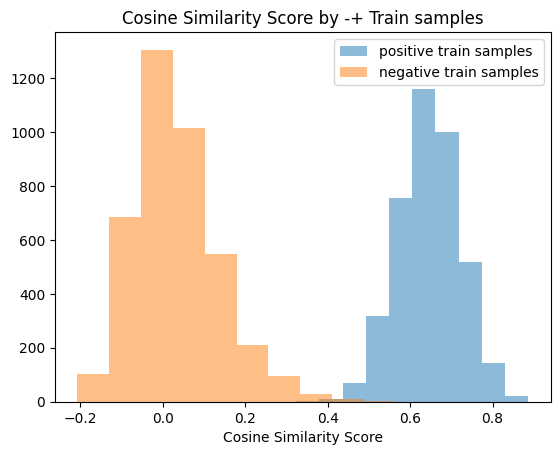

In [ ]:
pyplot.hist(pos_train_data['Score'], alpha=0.5, label='positive train samples')
pyplot.hist(neg_train_data['Score'], alpha=0.5, label='negative train samples')
pyplot.legend(loc='upper right')
pyplot.title('Cosine Similarity Score by -+ Train samples')
pyplot.xlabel('Cosine Similarity Score')
pyplot.show()

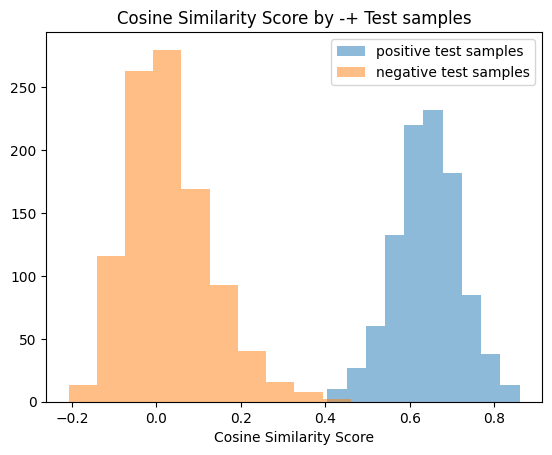

In [ ]:
pyplot.hist(pos_test_data['Score'], alpha=0.5, label='positive test samples')
pyplot.hist(neg_test_data['Score'], alpha=0.5, label='negative test samples')
pyplot.legend(loc='upper right')
pyplot.title('Cosine Similarity Score by -+ Test samples')
pyplot.xlabel('Cosine Similarity Score')
pyplot.show()